In [313]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
#print np in non-scientific notation
np.set_printoptions(suppress=True)


In [314]:

df = pd.read_feather('data/nq17-23_1min.feather')
df.index = df.index - pd.Timedelta(minutes=1)



In [315]:

tick_size = 0.25
#df['volume'] = df['volume'].astype(float)
df['body_size'] = (abs(df['close'] - df['open']) /tick_size).astype(int)
df['top_wick'] = ((df['high'] - df[['open', 'close']].max(axis=1)) /tick_size).astype(int)
df['bottom_wick'] = ((df[['open', 'close']].min(axis=1) - df['low']) /tick_size).astype(int)
df['direction'] = np.sign(df['close'] - df['open']).astype(int)

df['speed']  = df['bottom_wick'] * 2 + df['body_size'] + df['top_wick'] * 2
df.dropna(inplace=True)


In [316]:
#cut speef on 5 bins
df['speed_bin'] = pd.qcut(df['speed'], 10, labels=False)
df['speed_bin'].value_counts()

speed_bin
1    253577
0    251580
2    242439
7    240352
9    237111
6    235593
4    235056
8    232712
5    229878
3    214538
Name: count, dtype: int64

In [317]:

#df['type']  = np.nan
#df['type'] = df['type'].astype('str')
df.loc[df['close'] > df['open'], 'type'] ='G'
df.loc[df['close'] < df['open'], 'type'] = "R"
df.loc[df['close'] == df['open'], 'type'] = "D"
df.loc[df['high'] == df['low'], 'type'] = "Z"


#df['in_out'] = np.nan
#df['in_out'] = df['in_out'].astype('str')
df.loc[(df['high'] > df['high'].shift(1)) & (df['low'] < df['low'].shift(1)), 'in_out'] = 'I'
df.loc[(df['high'] < df['high'].shift(1)) & (df['low'] > df['low'].shift(1)), 'in_out'] = 'O'
df.loc[(df['high'] > df['high'].shift(1)) & (df['low'] > df['low'].shift(1)), 'in_out'] = 'H'
df.loc[(df['high'] < df['high'].shift(1)) & (df['low'] < df['low'].shift(1)), 'in_out'] = 'L'
df.loc[(df['high'] == df['high'].shift(1)) & (df['low'] == df['low'].shift(1)), 'in_out'] = 'Eq'
df.loc[(df['high'] == df['high'].shift(1)), 'in_out'] = 'Eh'
df.loc[(df['low'] == df['low'].shift(1)), 'in_out'] = 'El'
df = df.iloc[1:]

#Set feature for real trading hours and electronic trading hours
#df['trading_hours'] = np.where((df.index.hour >= 8) & (df.index.hour < 16), 'R', 'E')
df['hour'] = df.index.hour


In [318]:

#df['body'] = np.nan
#df['body'] = df['body'].astype('str')
df.loc[(df['close'] - df['open']).abs() == (df['high'] - df['low']), 'body'] = 'F'
df.loc[(df['type'] != 'Z') & ((df['close'] - df['open']).abs()/(df['high'] - df['low']) > 0.90), 'body'] = 'XL'
df.loc[(df['type'] != 'Z') & ((df['close'] - df['open']).abs()/(df['high'] - df['low']) <= 0.90) 
       & ((df['close'] - df['open']).abs()/(df['high'] - df['low']) > 0.6), 'body'] = 'L'
df.loc[(df['type'] != 'Z') & ((df['close'] - df['open']).abs()/(df['high'] - df['low']) <= 0.60) 
       & ((df['close'] - df['open']).abs()/(df['high'] - df['low']) > 0.4), 'body'] = 'M'
df.loc[(df['type'] != 'Z') & ((df['close'] - df['open']).abs()/(df['high'] - df['low']) <= 0.4) 
       & ((df['close'] - df['open']).abs()/(df['high'] - df['low']) > 0.1), 'body'] = 'S'
df.loc[(df['type'] != 'Z') & ((df['close'] - df['open']).abs()/(df['high'] - df['low']) <= 0.1), 'body'] = 'XS'

#df['body_shift'] = np.nan
#df['body_shift'] = df['body_shift'].astype('str')
df.loc[(df['type'] != 'Z') & ((df['close'] + df['open']).mean() > (df['high'] + df['low']).mean()), 'body_shift'] = 'T'
df.loc[(df['type'] != 'Z') & ((df['close'] + df['open']).mean() < (df['high'] + df['low']).mean()), 'body_shift'] = 'B'
df.loc[(df['type'] != 'Z') & ((df['close'] + df['open']).mean() == (df['high'] + df['low']).mean()), 'body_shift'] = 'C'



df['candle']  = df['type'] + df['in_out'] + df['body'] + df['body_shift'] + df['speed_bin'].astype('str') +":"+ df['hour'].astype('str')



In [319]:
df['candle']

date
2017-01-02 18:01:00-05:00      ROLT2:18
2017-01-02 18:02:00-05:00      GLST2:18
2017-01-02 18:03:00-05:00     GEhMT0:18
2017-01-02 18:04:00-05:00    GElXLT3:18
2017-01-02 18:05:00-05:00     RElLT4:18
                                ...    
2023-10-26 14:40:00-04:00      RLLT8:14
2023-10-26 14:41:00-04:00     GHXLT9:14
2023-10-26 14:42:00-04:00      RHST8:14
2023-10-26 14:43:00-04:00     ROXLT0:14
2023-10-26 14:44:00-04:00      RILT8:14
Name: candle, Length: 2372835, dtype: object

In [320]:
candle_class = df['candle'].value_counts().index.tolist()
candle_class_map = {candle_class[i]:i for i in range(len(candle_class))}
df['cluster'] = df['candle'].map(candle_class_map).astype('int64')  
    

In [321]:
df['cluster'].value_counts()

cluster
0        4181
1        3727
2        3250
3        3244
4        3227
         ... 
13501       1
13502       1
13503       1
13504       1
13505       1
Name: count, Length: 13506, dtype: int64

<Axes: >

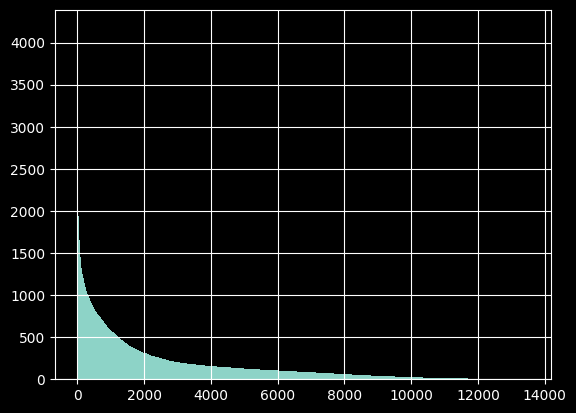

In [323]:
df['cluster'].hist(bins=13506)

In [190]:
# import h5py
# #read cluster  data from data/nq17-23_1min_candle_seq_1024.hdf5 ad add to df
# with h5py.File("data/nq17-23_1min_candle_seq_1024.hdf5", "r") as f:
#     df['cluster'] = f["data"][:]
    


In [324]:
df[df['cluster'] == 0]

,open,high,low,close,volume,body_size,top_wick,bottom_wick,direction,speed,speed_bin,type,in_out,hour,body,body_shift,candle,cluster
date,,,,,,,,,,,,,,,,,,
2017-06-12 10:05:00-04:00,5674.50,5677.75,5658.00,5658.25,3169,65,13,1,-1,93,9,R,L,10,L,T,RLLT9:10,0
2017-06-29 10:05:00-04:00,5694.25,5694.50,5683.00,5686.75,4555,30,1,15,-1,62,9,R,L,10,L,T,RLLT9:10,0
2017-08-02 10:27:00-04:00,5889.75,5889.75,5875.50,5878.00,3883,47,0,10,-1,67,9,R,L,10,L,T,RLLT9:10,0
2017-08-10 10:07:00-04:00,5844.50,5845.25,5832.00,5836.00,3190,34,3,16,-1,72,9,R,L,10,L,T,RLLT9:10,0
2017-08-24 10:08:00-04:00,5840.25,5840.50,5827.50,5831.00,3883,37,1,14,-1,67,9,R,L,10,L,T,RLLT9:10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-26 10:08:00-04:00,14327.00,14330.50,14311.25,14311.25,1834,63,14,0,-1,91,9,R,L,10,L,T,RLLT9:10,0
2023-10-26 10:12:00-04:00,14309.25,14312.25,14289.00,14291.75,3377,70,12,11,-1,116,9,R,L,10,L,T,RLLT9:10,0
2023-10-26 10:21:00-04:00,14300.00,14302.25,14284.50,14286.25,1553,55,9,7,-1,87,9,R,L,10,L,T,RLLT9:10,0


In [149]:
# from statsmodels.tsa.stattools import adfuller

# result = adfuller(df['top_wick'].iloc[0:100000])
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])

# # Вывод результатов
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

In [150]:

# body_list = sorted(df[['body'].unique().tolist())

# #convert value to index
# body_to_index = {v: (i) for i, v in enumerate(body_list)}

# #convert index to value
# index_to_body = {i: v for i, v in enumerate(body_list)}

# #apply mapping of value to index
# df['candle_index'] = df['body'].map(body_to_index)



In [15]:
# df.to_feather('data/nq17-23_1min_quantile_50.feather')
# #df = pd.read_feather('data/nq17-23_1min_quantile_100.feather')
# #df

In [10]:
# candles = torch.tensor(df['cluster'].values, dtype=torch.long)
# candles = candles.unfold(0, 2, 1)
# candles.unique(dim=1).shape

torch.Size([2372834, 2])

In [178]:
sizes_mean = df.groupby('cluster')[['top_wick', 'body_size', 'bottom_wick']].mean()
sizes_median = df.groupby('cluster')[['top_wick', 'body_size', 'bottom_wick']].median()
directions = df.groupby('cluster')['direction'].mean()

In [179]:
#convert sizes median dataframe to dict with quantile as key abd tuple of sizes as value
index_to_candles = sizes_median.to_dict('index')
index_to_candles = {k: tuple(v.values()) for k, v in index_to_candles.items()}
index_to_direction = directions.to_dict()

# merge sizes dict with directions dict in index_to_candles
for k, v in index_to_candles.items():
    index_to_candles[k] = {'sizes': v, 'direction': index_to_direction[k]}


In [180]:
def full_candle_restore(candle_index:(np.array,torch.Tensor), start_price:float, number_of_candles = None, index_map = index_to_candles) -> pd.DataFrame:
    '''
    Restore full candle from index of candle and start price
    '''
    if isinstance(candle_index, torch.Tensor):
        candle_index = candle_index.numpy()
    if number_of_candles is not None:
        candle_index = candle_index[:number_of_candles]
    
    
    candles = []
    for idx, cdl_idx in enumerate(candle_index):
        top_wick, body, bottom_wick = index_map[cdl_idx]['sizes']
        direction = index_map[cdl_idx]['direction']

        candle = {}
        if idx == 0:
            candle['open'] = start_price
        else:
            candle['open'] = candles[-1]['close']
        close = candle['open'] + body * tick_size * direction
        high = close + top_wick * tick_size if close > candle['open'] else candle['open'] + top_wick * tick_size
        low = candle['open'] - bottom_wick * tick_size if close > candle['open'] else close - bottom_wick * tick_size
        candle['high'] = high
        candle['low'] = low
        candle['close'] = close
        candles.append(candle)
    
    return pd.DataFrame(candles)

restored_df = full_candle_restore(df['cluster'].values, df['open'].values[0],number_of_candles=100)

In [181]:
#plot original and restored candles using plotly
import plotly.graph_objects as go
import plotly.express as px

original_candles = df[['open', 'high','low','close']].iloc[:restored_df.shape[0]]

fig = go.Figure(data=[go.Candlestick(x=original_candles.index,
                open=original_candles['open'],
                high=original_candles['high'],
                low=original_candles['low'],
                close=original_candles['close'])])


fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

fig = go.Figure(data=[go.Candlestick(x=restored_df.index,
                open=restored_df['open'],
                high=restored_df['high'],
                low=restored_df['low'],
                close=restored_df['close'])])
fig.update_layout(xaxis_rangeslider_visible=False)
# add text lable witn cluster number above each candle
fig.add_trace(go.Scatter(x=restored_df.index, y=restored_df['high'] + 0.5, text=df['cluster'].values[:restored_df.shape[0]], mode="text"))

fig.show()




In [12]:
#contstruct the tensor with  sequence of candles.
seq_columns = ['cluster']

seq_tensor = torch.tensor(df[seq_columns].values).reshape(-1)
# seq_tensor = seq_tensor[:seq_tensor.shape[0] //5*5] #cut the tail to make it dividable by 5

# # add 5 min divider token to the sequence

# mark_5min = torch.zeros(seq_tensor.shape[0],1, dtype=torch.int8)
# mark_5min = seq_tensor.max() + 1
# seq_tensor_5min = seq_tensor.view(-1,5)
# full_seq_tensor = torch.empty(seq_tensor_5min.shape[0], seq_tensor_5min.shape[1] + 1, dtype=torch.long)
# full_seq_tensor[:,:-1] = seq_tensor_5min
# full_seq_tensor[:,-1] = mark_5min
# seq_tensor = full_seq_tensor.reshape(-1)

In [13]:
seq_tensor = seq_tensor[~torch.isnan(seq_tensor)].to(torch.int64)


In [14]:

# save sequense tensor to hdf5
import h5py
with h5py.File('data/nq17-23_1min_candle_seq_manual.hdf5', 'w') as f:
       dataset = f.create_dataset('data', shape=seq_tensor.shape, dtype='i8')
       dataset[:] = seq_tensor[:]
       #save index_to_candle dictionary
       for key, value in index_to_candles.items():
              group = f.create_group(str(key))
              group.create_dataset('sizes', data=value['sizes'])
              group.create_dataset('direction', data=value['direction'])
              
       






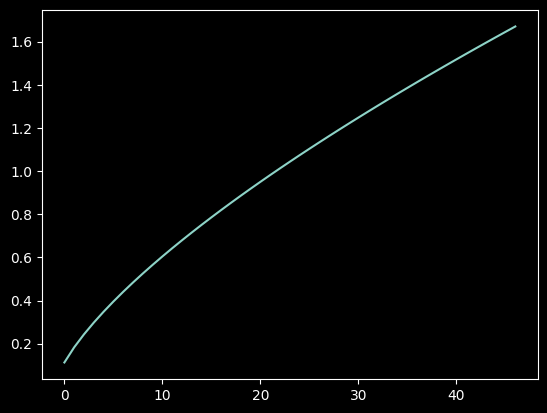

In [44]:
token_weights = (torch.arange(1, 48) ** 0.7)
# Нормализуем веса, чтобы сохранить ту же шкалу
token_weights = token_weights / token_weights.sum() * 47

plt.plot(token_weights)

In [45]:
token_weights

tensor([0.1128, 0.1833, 0.2434, 0.2977, 0.3480, 0.3954, 0.4405, 0.4836, 0.5252,
        0.5654, 0.6044, 0.6423, 0.6793, 0.7155, 0.7509, 0.7856, 0.8197, 0.8531,
        0.8860, 0.9184, 0.9503, 0.9818, 1.0128, 1.0435, 1.0737, 1.1036, 1.1331,
        1.1624, 1.1913, 1.2199, 1.2482, 1.2762, 1.3040, 1.3316, 1.3589, 1.3859,
        1.4128, 1.4394, 1.4658, 1.4920, 1.5180, 1.5438, 1.5695, 1.5949, 1.6202,
        1.6454, 1.6703])